## Part 1: Get top-5 selling products

In [1]:
# read data

import pandas as pd

historical_demand_csv_path = (
    "C:/Users/hachatur/gd/scratch/sarang_forecast/product_demand_raw.csv"
)
hist_raw_df = pd.read_csv(historical_demand_csv_path)

print("hist_raw_df =")
with pd.option_context("display.max_columns", None, "display.width", 1000):
    print(hist_raw_df)

hist_raw_df =
       Order ID                     Product Quantity Ordered Price Each      Order Date                        Purchase Address
0        141234                      iPhone                1        700  01/22/19 21:25         944 Walnut St, Boston, MA 02215
1        141235    Lightning Charging Cable                1      14.95  01/28/19 14:15        185 Maple St, Portland, OR 97035
2        141236            Wired Headphones                2      11.99  01/17/19 13:33   538 Adams St, San Francisco, CA 94016
3        141237            27in FHD Monitor                1     149.99  01/05/19 20:33      738 10th St, Los Angeles, CA 90001
4        141238            Wired Headphones                1      11.99  01/25/19 11:59           387 10th St, Austin, TX 73301
...         ...                         ...              ...        ...             ...                                     ...
186845   319666    Lightning Charging Cable                1      14.95  12/11/19 20:58  1

hist_df =
                 timestamp                     product  qty   price
0      2019-01-22 21:25:00                      iPhone    1  700.00
1      2019-01-28 14:15:00    Lightning Charging Cable    1   14.95
2      2019-01-17 13:33:00            Wired Headphones    2   11.99
3      2019-01-05 20:33:00            27in FHD Monitor    1  149.99
4      2019-01-25 11:59:00            Wired Headphones    1   11.99
...                    ...                         ...  ...     ...
186845 2019-12-11 20:58:00    Lightning Charging Cable    1   14.95
186846 2019-12-01 12:01:00       AA Batteries (4-pack)    2    3.84
186847 2019-12-09 06:43:00             Vareebadd Phone    1  400.00
186848 2019-12-03 10:39:00            Wired Headphones    1   11.99
186849 2019-12-21 21:45:00  Bose SoundSport Headphones    1   99.99

[185950 rows x 4 columns]


Text(0.5, 1.0, 'price histogram')

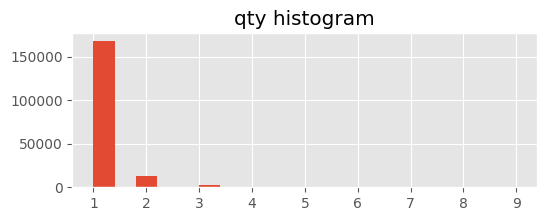

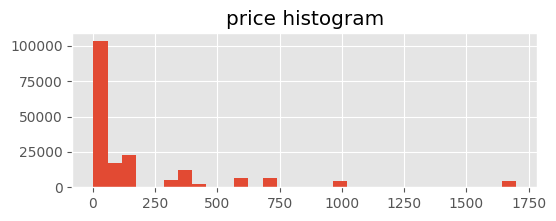

In [2]:
# clean data

import matplotlib.pyplot as plt

# set seaborn style for plots
plt.style.use("ggplot")

# format columns and drop nans
hist_df = hist_raw_df[
    ["Order Date", "Product", "Quantity Ordered", "Price Each"]
].copy().rename(
    columns={
        "Order Date": "timestamp",
        "Product": "product",
        "Quantity Ordered": "qty",
        "Price Each": "price",
    }
)
hist_df["timestamp"] = pd.to_datetime(hist_df["timestamp"], format="%m/%d/%y %H:%M", errors="coerce")
hist_df.dropna(inplace=True)
hist_df["qty"] = hist_df["qty"].astype(int)
hist_df["price"] = hist_df["price"].astype(float)
hist_df.dropna(inplace=True)

print("hist_df =")
with pd.option_context("display.max_columns", None, "display.width", 1000):
    print(hist_df)

# plot histograms of price and quantity to check for outliers
ax = hist_df["qty"].hist(bins=20, ax=plt.subplots(figsize=(6, 2))[1])
ax.set_title("qty histogram")
ax = hist_df["price"].hist(bins=30, ax=plt.subplots(figsize=(6, 2))[1])
ax.set_title("price histogram")


Outlier analysis observations
* 'qty' and 'price' values look outlier-free; no negatives or absurdly large values
* We will skip outlier removal at this stage


top-5-revenue products = ['Macbook Pro Laptop', 'iPhone', 'ThinkPad Laptop', 'Google Phone', '27in 4K Gaming Monitor']


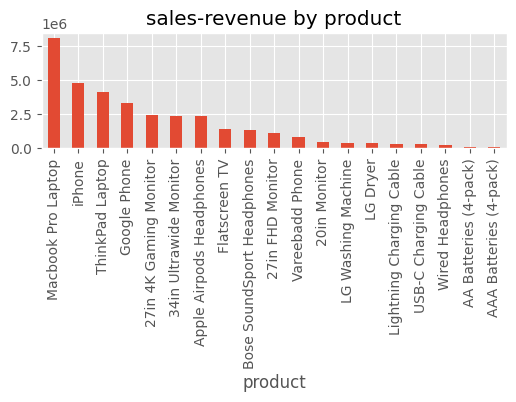

In [3]:
# get top-5 products by sales-revenue (sales dollar value)

hist_df["revenue"] = hist_df["qty"] * hist_df["price"]

# group by product and sum revenue
revenue_ser = hist_df.groupby("product")["revenue"].sum().sort_values(
    ascending=False
)

ax = revenue_ser.plot(kind="bar", ax=plt.subplots(figsize=(6, 1.5))[1])
ax.set_title("sales-revenue by product")

# get top-5 products
top_products = revenue_ser.index[:5].to_list()

print(f"\ntop-5-revenue products = {top_products}")

## Part 2: Forecast next-week demand of top-5 sellers


demand_pred_result = 
{'forecast_week_qty': 184,
 'forecast_week_starttime': '2020-01-01 00:00:00',
 'validation_error_wmape_pct': 11,
 'validation_period_weeks': 10}


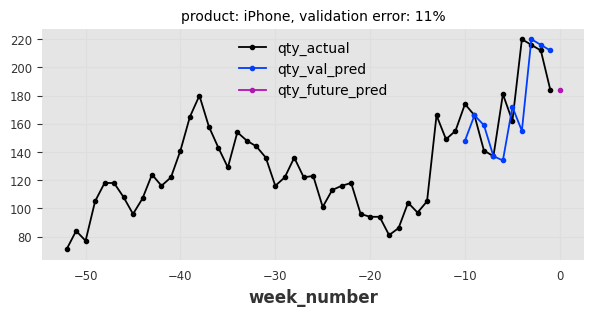

In [62]:

from darts import TimeSeries
from darts.models import StatsForecastAutoARIMA
from darts.utils.statistics import check_seasonality
from pprint import pprint
import numpy as np

class ProductDemandPredictor:
    def __init__(
        self, 
        product_name: str,
        compute_validation_error: bool=True
    ):
        self.product_name = product_name
        self.compute_validation_error = compute_validation_error
        self.forecast_starttime = None
        self.model = None
        self.validation_df = None
        self.validation_error_wmape_pct = None
        self.validation_period_weeks = None

    def fit(
        self,
        all_products_demand_df: pd.DataFrame,
        forecast_starttime: str | pd.Timestamp,
    ):
        # get demand history for product: hist_prodt_df
        # * we discard sales after forecast_starttime
        forecast_starttime = pd.to_datetime(forecast_starttime)
        self.forecast_starttime = forecast_starttime
        hist_prodt_df = all_products_demand_df[
            (all_products_demand_df["product"] == self.product_name)
            & (all_products_demand_df["timestamp"] <= forecast_starttime)
        ].copy()

        # compute a week_number for each sale
        # * note that we want 
        #   * week_number for the forecasted week to be 0
        #   * week_number to increase with time
        # * so week_number will be negative for sales before forecast_starttime
        hist_prodt_df["weeks_to_forecast"] = (
            forecast_starttime - hist_prodt_df["timestamp"]
        ) / pd.to_timedelta("7d")
        hist_prodt_df["week_number"] = -(
            hist_prodt_df["weeks_to_forecast"].apply(np.ceil).astype(int)
        )

        # compute weekly demand: hist_weekly_df
        # * fill any missing weeks with 0 qty
        # * drop earliest week due to potential incomplete data
        qty_weekly_df = (
            hist_prodt_df.groupby("week_number")
            .agg({"qty": "sum"})
        )
        qty_weekly_df = qty_weekly_df.reindex(
            range(qty_weekly_df.index.min(), 0), fill_value=0
        )
        qty_weekly_df = qty_weekly_df.iloc[1:None]

        # convert qty_weekly_df to a darts TimeSeries: qty_tser
        qty_tser = TimeSeries.from_dataframe(
            qty_weekly_df,
            value_cols="qty",
        )

        # get the dominant seasonality of the data
        (is_seasonal, season_len) = check_seasonality(qty_tser)

        # init the forecast model
        self.model = StatsForecastAutoARIMA(
            seasonal=is_seasonal,
            season_length=season_len,
        )

        # backtest and compute validation error (wmape) for the model
        if compute_validation_error:
            validation_period_as_history_frac = 0.2
            validation_period_len = int(
                validation_period_as_history_frac * len(qty_tser)
            )
            self.validation_period_weeks = validation_period_len
            val_pred_ser = self.model.historical_forecasts(
                qty_tser,
                start=-validation_period_len,
                forecast_horizon=1,
            )
            val_df = val_pred_ser.to_dataframe().round(0)
            val_df.rename(
                columns={"qty": "qty_val_pred"}, inplace=True
            )
            val_df = qty_tser.to_dataframe().join(
                val_df,
                how="left",
            )
            val_df.rename(
                columns={"qty": "qty_actual"}, inplace=True
            )
            self.validation_df = val_df
            val_main_df = val_df.dropna()
            wmape = None
            abs_error_sum = np.abs(
                val_main_df["qty_actual"] - val_main_df["qty_val_pred"]).sum()
            qty_actual_sum = val_main_df["qty_actual"].sum()
            if qty_actual_sum > 0:
                wmape = round((abs_error_sum / qty_actual_sum) * 100)
            elif qty_actual_sum == 0 and abs_error_sum == 0:
                wmape = 0
            else: # qty_actual_sum == 0 and abs_error_sum > 0
                wmape = 100
            self.validation_error_wmape_pct = wmape

        # fit the model
        self.model.fit(qty_tser)

    def predict(self):
        """Predict next-week demand for the product"""

        # compute result
        next_week_demand = round(self.model.predict(1).values()[0][0])
        if self.validation_df is not None:
            # add prediction to validation_df
            if "qty_future_pred" not in self.validation_df.columns.to_list():
                self.validation_df["qty_future_pred"] = np.nan
            self.validation_df.loc[0] = (np.nan, np.nan, next_week_demand)
        result = {
            "forecast_week_qty": next_week_demand,
            "forecast_week_starttime": str(self.forecast_starttime),
            "validation_error_wmape_pct": self.validation_error_wmape_pct,
            "validation_period_weeks": self.validation_period_weeks,
            "validation_df": self.validation_df,
        }

        return result

    def plot_validation_df(self):
        ax = plt.subplots(figsize=(7, 3))[1]
        validation_df = self.validation_df.copy()
        validation_df.columns = validation_df.columns.to_list()
        validation_df.plot(
            kind="line",
            ax = ax,
            marker=".",
        )
        ax.title.set_text(f"product: {self.product_name}, validation error: {self.validation_error_wmape_pct}%")
        ax.title.set_fontsize(10)
        return ax

# example usage
product_name = 'iPhone'
forecast_starttime = "2020-01-01"
demand_predictor = ProductDemandPredictor(product_name)
demand_predictor.fit(hist_df, forecast_starttime)
demand_pred_result = demand_predictor.predict()
demand_pred_result = {
    k: v for k, v in demand_pred_result.items() if k != "validation_df"
}
print(f"\ndemand_pred_result = ")
pprint(demand_pred_result, sort_dicts=False)
_ = demand_predictor.plot_validation_df()

{'forecast_week_qty': 187,
 'forecast_week_starttime': '2020-01-01 00:00:00',
 'validation_error_wmape_pct': 9,
 'validation_period_weeks': 10,
 'validation_df': component    qty_actual  qty_val_pred  qty_future_pred
 week_number                                           
 -52                81.0           NaN              NaN
 -51                75.0           NaN              NaN
 -50                59.0           NaN              NaN
 -49                68.0           NaN              NaN
 -48                97.0           NaN              NaN
 -47               125.0           NaN              NaN
 -46                97.0           NaN              NaN
 -45                97.0           NaN              NaN
 -44               105.0           NaN              NaN
 -43               111.0           NaN              NaN
 -42               108.0           NaN              NaN
 -41               107.0           NaN              NaN
 -40               116.0           NaN              NaN

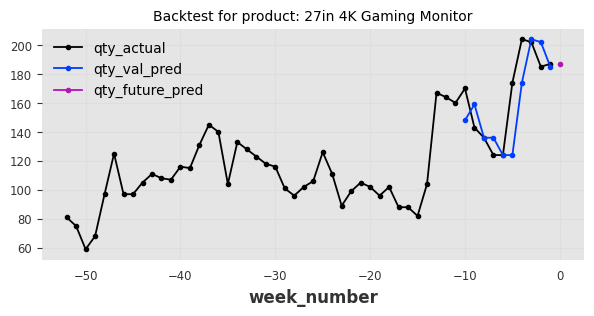

In [55]:

# ['Macbook Pro Laptop', 'iPhone', 'ThinkPad Laptop', 'Google Phone', '27in 4K Gaming Monitor']

product_name = "27in 4K Gaming Monitor"
forecast_starttime = "2020-01-01"
demand_predictor = ProductDemandPredictor(product_name)
demand_predictor.fit(hist_df, forecast_starttime)
demand_pred_result = demand_predictor.predict()
demand_predictor.plot_validation_df(
    demand_pred_result["validation_df"], product_name
)

demand_pred_result